In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('Exercise1 - data.csv', header=None)

In [3]:
# Convert malignant and benign to numerical values: Malilgnant to 1 and Benign to 0
df[1] = df[1].map({'M':1, 'B':0})

In [4]:
# Randomly choose 60% of the dataset for training, 20% for cross-validation and 20% for testing
train_dataset = df.sample(frac=0.8, random_state=1)
test_dataset = df.drop(train_dataset.index)

In [5]:
# Generates descriptive statistics that summarize the central tendency, 
# dispersion and shape of a dataset's distribution, excluding NaN values
train_stats = train_dataset.describe()
train_stats.pop(0)
train_stats.pop(1)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
2,455.0,14.121527,3.562156,6.981000,11.675000,13.400000,15.780000,28.11000
3,455.0,19.233077,4.148890,10.380000,16.265000,18.840000,21.680000,33.81000
4,455.0,91.940505,24.565707,43.790000,75.100000,86.490000,105.000000,188.50000
5,455.0,655.110769,353.070360,143.500000,417.950000,552.400000,782.650000,2499.00000
6,455.0,0.096328,0.014374,0.052630,0.085640,0.095970,0.105000,0.16340
7,455.0,0.103993,0.053266,0.023440,0.064330,0.092420,0.129800,0.34540
8,455.0,0.089082,0.081465,0.000000,0.029520,0.061540,0.126950,0.42680
9,455.0,0.048667,0.038894,0.000000,0.019575,0.033900,0.073700,0.20120
10,455.0,0.180609,0.026749,0.120300,0.161850,0.178400,0.194850,0.29060
11,455.0,0.062799,0.007019,0.049960,0.057695,0.061550,0.066040,0.09744


In [6]:
# Split features from labels
train_labels = train_dataset.pop(1)
test_labels = test_dataset.pop(1)
# Get rid of the ids - they are not relevant for classification
train_dataset.pop(0)
test_dataset.pop(0)
# Make sure the labels are treated as 2d arrays that can be fed into placeholder for Y
# Transpose to keep the 'vertical' shape
train_labels = np.transpose(np.atleast_2d(train_labels))
test_labels = np.transpose(np.atleast_2d(test_labels))

In [7]:
# Normalize the data using mean and standard deviation - intentionally use stats
# from only the training set, these statistics will aslo be used for evaluation.
# This is so that the model doesn't have any information about the test set.
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [8]:
# Insert a column with constant value for the constant parameter in classification
normed_train_data.insert(0, column='CONST', value=1)
normed_test_data.insert(0, column='CONST', value=1)

In [9]:
n_dim = normed_train_data.shape
n_dim

(455, 31)

In [18]:
# Parameters 
learning_rate = 0.0003
training_epochs = 12000
cost_history = np.empty(shape=[1], dtype=float)
# Parameter for regularization
lbd = [0, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.5, 5, 10]
# Graph input and model weights
X = tf.placeholder(tf.float32, [None, n_dim[1]])
Y = tf.placeholder(tf.float32, [None, 1])
W = tf.Variable(tf.ones([n_dim[1] ,1]))

init = tf.global_variables_initializer()

In [24]:
# Multiply features matrix to weights matrix and can be used for prediction
y_ = tf.nn.sigmoid(tf.matmul(X, W))
# Minimize error using cross entropy
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_, labels=Y)+0.25*tf.nn.l2_loss(W[1:]))
# Perform one step of gradient descent optimisation to minimise the cost fucntion
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [25]:
# Training of the logistic regression model
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step, feed_dict={X:normed_train_data,Y:train_labels})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X:normed_train_data,Y:train_labels}))

1.2597945928573608


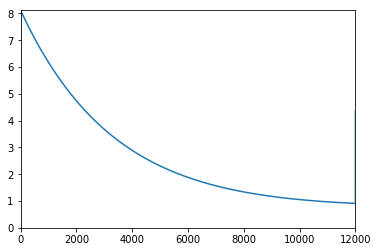

In [26]:
plt.plot(range(len(cost_history)),cost_history)
print(cost_history[-1])
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

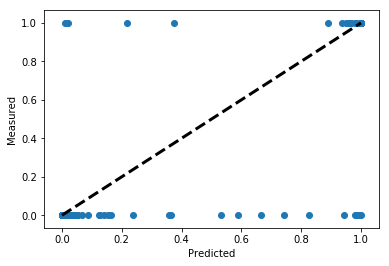

In [27]:
pred_y = sess.run(y_, feed_dict={X:normed_test_data})

fig, ax = plt.subplots()
ax.scatter(pred_y, test_labels)
ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Measured')
plt.show()

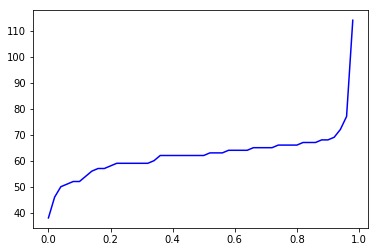

In [28]:
# evaluate the histogram
values, base = np.histogram(pred_y, bins=50)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')
plt.xlabel('Probability')
ax.set_ylabel('Measured')
plt.show()

In [33]:
TP = 0
TN = 0
FP = 0
FN = 0
i = 0
for result in pred_y:
    if result>0.9 and test_labels[i]==1:
        TP+=1
    if result>0.9 and test_labels[i]==0:
        FP+=1
    if result<0.9 and test_labels[i]==1:
        FN+=1
    if result<0.9 and test_labels[i]==0:
        TN+=1
    i+=1
print([TN, FP])
print([FN, TP])

[63, 6]
[5, 40]


In [34]:
precision = round(TP/(TP+FP), 2)
recall = round(TP/(TP+FN),2)
F1 = round(2*precision*recall/(precision+recall),2)
accuracy = round((TP+TN)/(TP+FP+FN+TN), 2)
print('Precision: ',precision,'\nRecall: ',recall,'\nF1: ',F1,'\nAccuracy:', accuracy)


Precision:  0.87 
Recall:  0.89 
F1:  0.88 
Accuracy: 0.9
